In [1]:
from climpyrical.gridding import scale_model_obs
from climpyrical.mask import stratify_coords
from climpyrical.data import read_data, interpolate_dataset, gen_dataset
from climpyrical.rkrig import rkrig_r
from climpyrical.cmd.find_matched_model_vals import add_model_values

from pkg_resources import resource_filename

from sklearn.neighbors import NearestNeighbors
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

### Parameters are loaded from config_example.yml
Example configuration from config_example.yml:
```
    paths:
        preprocessed_model_path: /data/results/intermediate/preprocessed_netcdf/
    RL50:
        station_dv: "RL50 (kPa)"
        station_path: 'data/station_inputs/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv'
        input_model_path: 'data/model_inputs/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
        medians: 
            value: 0.4
            action: "multiply"
        fill_glaciers: True
```

In [2]:
# parameter cell

In [3]:
# Parameters
name = "TJan1.0"
station_dv = "TJan1.0 (degC)"
station_path = "data/station_inputs/janT2.5p_T1.0p_allstations_v3_min8yr_for_maps.csv"
input_model_path = (
    "data/model_inputs/tas_CanRCM4-LE_ens35_1951-2016_1hr_jan1.0p_ensmean.nc"
)
medians = {"value": -27, "action": "add"}
fill_glaciers = True
output_notebook_path = "/data/results/intermediate/notebooks/"
preprocessed_model_path = "/data/results/intermediate/preprocessed_netcdf/"
preprocessed_stations_path = "/data/results/intermediate/preprocessed_stations/"
output_reconstruction_path = "/data/results/netcdf/"
output_tables_path = "/data/results/TableC2/"
output_figure_path = "/data/results/figures/"
mask_path = "data/masks/canada_mask_rp.nc"
north_mask_path = "data/masks/canada_mask_north_rp.nc"
nbcc_loc_path = "data/station_inputs/NBCC_2020_new_coords.xlsm"
nbcc_median_correction = True


Load processed moded, target canada-only mask, and the Upper Artic Area mask 

In [4]:
# Hard coded CanRCM4 upper model domain rlat
dsold_max = 28.15999984741211

ds = read_data(resource_filename("climpyrical", f"{preprocessed_model_path}{name}.nc"))
(dv, ) = ds.data_vars

mask = read_data(
    resource_filename(
        'climpyrical',
        mask_path
    ))['mask'].values

northern_mask = read_data(
    resource_filename(
        'climpyrical',
        north_mask_path
    )
)['mask'].values

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

Load processed station data

In [5]:
df = pd.read_csv(
    resource_filename(
        "climpyrical",
        f"{preprocessed_stations_path}{name}.csv"
    ), 
    index_col=False
)
df.head(3)

,irlat,irlon,TJan1.0 (degC),rlat,rlon,lat,lon,elev (m),station_name,province,model_values,ratio
0,552,1011,-18.4,-4.517790,10.457750,42.0333,-82.9000,191,HARROW CDA AUTO,ON,-17.046537,0.988608
1,558,1009,-19.0,-4.286849,10.373390,42.2756,-82.9556,190,WINDSOR A,ON,-17.771767,0.989080
2,560,1026,-17.1,-4.166610,11.147744,42.2501,-81.9001,178,ERIEAU (AUT),ON,-16.925684,0.993184


In [6]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    K = 273.15
    df[station_dv] += K
    df["model_values"] += K
    ds[dv] += K

Separate stations into beyond and within the model domain

In [7]:
df_north = df[df.rlat > dsold_max].copy()
df_south = df[df.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

Check for sets of stations that are identical. This would produce idential windows over a geographic area and disproportionately weight them in the averaged ratio field.

In [8]:
X_distances = np.stack([np.deg2rad(df_south.lat.values), np.deg2rad(df_south.lon.values)])
nbrs = NearestNeighbors(n_neighbors=30, metric="haversine").fit(
    X_distances.T
)

# Order independent window checkers
# only uses windows that are not-identical

dist, ind = nbrs.kneighbors(X_distances.T)
good_i = []
list_of_sets = []
count = 0 
for i in range(df_south.shape[0]):
    list_of_sets.append(df_south[["lon", "lat", station_dv]].iloc[ind[i]].values)
    if i+1-count == np.unique(list_of_sets, axis=0).shape[0]:
        good_i.append(i)
    else:
        warning.warn("There are identical windows!")
        count += 1 

df_south = df_south.iloc[good_i]

Calculate the station average in the UAA

In [9]:
UAA_station_mean = np.nanmean(df[station_dv][df.rlat > dsold_max-1])
UAA_station_mean

229.84999999999997

Use the best tolerance scaling to scale the model values. The ratio is already automatically scaled.

In [10]:
model_vals = df.model_values
station_vals = df[station_dv]

ratio, best_tol = scale_model_obs(df.model_values, station_vals)

# apply correction
model_vals_corrected = (model_vals/best_tol)
mean_corrected = (ds[dv].values/best_tol)

Perform ratio kriging on the set of stations below the maximum CanRCM4 native domain.

In [11]:
ratio_field = rkrig_r(df_south, 30, ds, station_dv)
ratio_field[~mask] = np.nan

  0%|          | 0/369 [00:00<?, ?it/s]

  1%|          | 2/369 [00:00<01:50,  3.33it/s]

  1%|          | 3/369 [00:01<02:21,  2.59it/s]

  1%|          | 4/369 [00:01<02:42,  2.25it/s]

  1%|▏         | 5/369 [00:02<02:56,  2.06it/s]

  2%|▏         | 6/369 [00:02<03:06,  1.95it/s]

  2%|▏         | 7/369 [00:03<03:11,  1.89it/s]

  2%|▏         | 8/369 [00:04<03:12,  1.87it/s]

  2%|▏         | 9/369 [00:04<03:17,  1.83it/s]

  3%|▎         | 10/369 [00:05<03:21,  1.78it/s]

  3%|▎         | 11/369 [00:05<03:16,  1.83it/s]

  3%|▎         | 12/369 [00:06<03:17,  1.80it/s]

  4%|▎         | 13/369 [00:06<03:16,  1.81it/s]

  4%|▍         | 14/369 [00:07<03:21,  1.77it/s]

  4%|▍         | 15/369 [00:07<03:16,  1.80it/s]

  4%|▍         | 16/369 [00:08<03:15,  1.80it/s]

  5%|▍         | 17/369 [00:09<03:16,  1.80it/s]

  5%|▍         | 18/369 [00:09<03:20,  1.75it/s]

  5%|▌         | 19/369 [00:10<03:19,  1.76it/s]

  5%|▌         | 20/369 [00:10<03:18,  1.76it/s]

  6%|▌         | 21/369 [00:11<03:15,  1.78it/s]

  6%|▌         | 22/369 [00:11<03:13,  1.80it/s]

  6%|▌         | 23/369 [00:12<03:18,  1.74it/s]

  7%|▋         | 24/369 [00:13<03:19,  1.73it/s]

  7%|▋         | 25/369 [00:13<03:19,  1.72it/s]

  7%|▋         | 26/369 [00:14<03:17,  1.73it/s]

  7%|▋         | 27/369 [00:14<03:24,  1.67it/s]

  8%|▊         | 28/369 [00:15<03:21,  1.69it/s]

  8%|▊         | 29/369 [00:16<03:18,  1.72it/s]

  8%|▊         | 30/369 [00:16<03:14,  1.74it/s]

  8%|▊         | 31/369 [00:17<03:12,  1.75it/s]

  9%|▊         | 32/369 [00:17<03:07,  1.79it/s]

  9%|▉         | 33/369 [00:18<03:08,  1.78it/s]

  9%|▉         | 34/369 [00:18<03:09,  1.77it/s]

  9%|▉         | 35/369 [00:19<03:07,  1.78it/s]

 10%|▉         | 36/369 [00:19<03:01,  1.83it/s]

 10%|█         | 37/369 [00:20<03:02,  1.82it/s]

 10%|█         | 38/369 [00:21<03:02,  1.81it/s]

 11%|█         | 39/369 [00:21<03:00,  1.83it/s]

 11%|█         | 40/369 [00:22<02:56,  1.87it/s]

 11%|█         | 41/369 [00:22<02:57,  1.85it/s]

 11%|█▏        | 42/369 [00:23<03:01,  1.80it/s]

 12%|█▏        | 43/369 [00:23<03:00,  1.80it/s]

 12%|█▏        | 44/369 [00:24<02:58,  1.82it/s]

 12%|█▏        | 45/369 [00:24<02:59,  1.81it/s]

 12%|█▏        | 46/369 [00:25<03:00,  1.79it/s]

 13%|█▎        | 47/369 [00:26<03:00,  1.78it/s]

 13%|█▎        | 48/369 [00:26<02:59,  1.78it/s]

 13%|█▎        | 49/369 [00:27<02:56,  1.82it/s]

 14%|█▎        | 50/369 [00:27<02:58,  1.79it/s]

 14%|█▍        | 51/369 [00:28<03:02,  1.74it/s]

 14%|█▍        | 52/369 [00:28<03:15,  1.62it/s]

 14%|█▍        | 53/369 [00:29<03:05,  1.70it/s]

 15%|█▍        | 54/369 [00:30<02:57,  1.77it/s]

 15%|█▍        | 55/369 [00:30<02:53,  1.81it/s]

 15%|█▌        | 56/369 [00:31<02:51,  1.83it/s]

 15%|█▌        | 57/369 [00:31<02:49,  1.84it/s]

 16%|█▌        | 58/369 [00:32<02:49,  1.83it/s]

 16%|█▌        | 59/369 [00:32<02:48,  1.84it/s]

 16%|█▋        | 60/369 [00:33<02:47,  1.85it/s]

 17%|█▋        | 61/369 [00:33<02:42,  1.90it/s]

 17%|█▋        | 62/369 [00:34<02:58,  1.72it/s]

 17%|█▋        | 63/369 [00:34<02:54,  1.76it/s]

 17%|█▋        | 64/369 [00:35<02:48,  1.81it/s]

 18%|█▊        | 65/369 [00:36<02:48,  1.81it/s]

 18%|█▊        | 66/369 [00:36<02:47,  1.81it/s]

 18%|█▊        | 67/369 [00:37<02:47,  1.80it/s]

 18%|█▊        | 68/369 [00:37<02:47,  1.80it/s]

 19%|█▊        | 69/369 [00:38<02:45,  1.81it/s]

 19%|█▉        | 70/369 [00:38<02:46,  1.80it/s]

 19%|█▉        | 71/369 [00:39<02:46,  1.79it/s]

 20%|█▉        | 72/369 [00:39<02:45,  1.79it/s]

 20%|█▉        | 73/369 [00:40<03:03,  1.62it/s]

 20%|██        | 74/369 [00:41<02:55,  1.68it/s]

 20%|██        | 75/369 [00:41<02:47,  1.76it/s]

 21%|██        | 76/369 [00:42<02:43,  1.79it/s]

 21%|██        | 77/369 [00:42<02:40,  1.82it/s]

 21%|██        | 78/369 [00:43<02:45,  1.76it/s]

 21%|██▏       | 79/369 [00:43<02:42,  1.79it/s]

 22%|██▏       | 80/369 [00:44<02:43,  1.76it/s]

 22%|██▏       | 81/369 [00:45<02:41,  1.78it/s]

 22%|██▏       | 82/369 [00:45<02:35,  1.85it/s]

 22%|██▏       | 83/369 [00:46<02:36,  1.83it/s]

 23%|██▎       | 84/369 [00:46<02:33,  1.86it/s]

 23%|██▎       | 85/369 [00:47<02:29,  1.89it/s]

 23%|██▎       | 86/369 [00:47<02:34,  1.83it/s]

 24%|██▎       | 87/369 [00:48<02:35,  1.82it/s]

 24%|██▍       | 88/369 [00:48<02:36,  1.79it/s]

 24%|██▍       | 89/369 [00:49<02:37,  1.77it/s]

 24%|██▍       | 90/369 [00:50<02:42,  1.72it/s]

 25%|██▍       | 91/369 [00:50<02:42,  1.71it/s]

 25%|██▍       | 92/369 [00:51<02:36,  1.77it/s]

 25%|██▌       | 93/369 [00:51<02:27,  1.87it/s]

 25%|██▌       | 94/369 [00:52<02:24,  1.91it/s]

 26%|██▌       | 95/369 [00:52<02:26,  1.87it/s]

 26%|██▌       | 96/369 [00:53<02:27,  1.85it/s]

 26%|██▋       | 97/369 [00:53<02:29,  1.81it/s]

 27%|██▋       | 98/369 [00:54<02:28,  1.83it/s]

 27%|██▋       | 99/369 [00:54<02:23,  1.88it/s]

 27%|██▋       | 100/369 [00:55<02:25,  1.85it/s]

 27%|██▋       | 101/369 [00:56<02:26,  1.83it/s]

 28%|██▊       | 102/369 [00:56<02:24,  1.85it/s]

 28%|██▊       | 103/369 [00:57<02:19,  1.91it/s]

 28%|██▊       | 104/369 [00:57<02:21,  1.88it/s]

 28%|██▊       | 105/369 [00:58<02:21,  1.86it/s]

 29%|██▊       | 106/369 [00:58<02:20,  1.88it/s]

 29%|██▉       | 107/369 [00:59<02:39,  1.64it/s]

 29%|██▉       | 108/369 [01:00<02:37,  1.66it/s]

 30%|██▉       | 109/369 [01:00<02:36,  1.66it/s]

 30%|██▉       | 110/369 [01:01<02:26,  1.77it/s]

 30%|███       | 111/369 [01:01<02:31,  1.70it/s]

 30%|███       | 112/369 [01:02<02:25,  1.76it/s]

 31%|███       | 113/369 [01:02<02:19,  1.84it/s]

 31%|███       | 114/369 [01:03<02:14,  1.90it/s]

 31%|███       | 115/369 [01:03<02:30,  1.69it/s]

 31%|███▏      | 116/369 [01:04<02:26,  1.73it/s]

 32%|███▏      | 117/369 [01:05<02:24,  1.75it/s]

 32%|███▏      | 118/369 [01:05<02:18,  1.81it/s]

 32%|███▏      | 119/369 [01:06<02:16,  1.83it/s]

 33%|███▎      | 120/369 [01:06<02:17,  1.81it/s]

 33%|███▎      | 121/369 [01:07<02:16,  1.82it/s]

 33%|███▎      | 122/369 [01:07<02:12,  1.86it/s]

 33%|███▎      | 123/369 [01:08<02:11,  1.87it/s]

 34%|███▎      | 124/369 [01:08<02:09,  1.89it/s]

 34%|███▍      | 125/369 [01:09<02:12,  1.84it/s]

 34%|███▍      | 126/369 [01:09<02:07,  1.91it/s]

 34%|███▍      | 127/369 [01:10<02:09,  1.87it/s]

 35%|███▍      | 128/369 [01:10<02:07,  1.89it/s]

 35%|███▍      | 129/369 [01:11<02:08,  1.86it/s]

 35%|███▌      | 130/369 [01:12<02:07,  1.88it/s]

 36%|███▌      | 131/369 [01:12<02:06,  1.88it/s]

 36%|███▌      | 132/369 [01:13<02:08,  1.85it/s]

 36%|███▌      | 133/369 [01:13<02:08,  1.83it/s]

 36%|███▋      | 134/369 [01:14<02:06,  1.86it/s]

 37%|███▋      | 135/369 [01:14<02:03,  1.90it/s]

 37%|███▋      | 136/369 [01:15<02:04,  1.88it/s]

 37%|███▋      | 137/369 [01:15<02:05,  1.85it/s]

 37%|███▋      | 138/369 [01:16<02:06,  1.83it/s]

 38%|███▊      | 139/369 [01:16<02:05,  1.84it/s]

 38%|███▊      | 140/369 [01:17<02:05,  1.82it/s]

 38%|███▊      | 141/369 [01:18<02:06,  1.80it/s]

 38%|███▊      | 142/369 [01:18<02:06,  1.80it/s]

 39%|███▉      | 143/369 [01:19<02:08,  1.77it/s]

 39%|███▉      | 144/369 [01:19<02:04,  1.80it/s]

 39%|███▉      | 145/369 [01:20<02:04,  1.79it/s]

 40%|███▉      | 146/369 [01:20<02:03,  1.80it/s]

 40%|███▉      | 147/369 [01:21<02:01,  1.83it/s]

 40%|████      | 148/369 [01:21<01:59,  1.84it/s]

 40%|████      | 149/369 [01:22<01:59,  1.84it/s]

 41%|████      | 150/369 [01:22<01:59,  1.83it/s]

 41%|████      | 151/369 [01:23<02:03,  1.77it/s]

 41%|████      | 152/369 [01:24<02:04,  1.74it/s]

 41%|████▏     | 153/369 [01:24<02:05,  1.72it/s]

 42%|████▏     | 154/369 [01:25<02:00,  1.78it/s]

 42%|████▏     | 155/369 [01:25<02:03,  1.74it/s]

 42%|████▏     | 156/369 [01:26<02:00,  1.76it/s]

 43%|████▎     | 157/369 [01:27<02:00,  1.75it/s]

 43%|████▎     | 158/369 [01:27<01:58,  1.78it/s]

 43%|████▎     | 159/369 [01:28<01:56,  1.80it/s]

 43%|████▎     | 160/369 [01:28<01:55,  1.81it/s]

 44%|████▎     | 161/369 [01:29<01:53,  1.84it/s]

 44%|████▍     | 162/369 [01:29<01:55,  1.79it/s]

 44%|████▍     | 163/369 [01:30<01:54,  1.79it/s]

 44%|████▍     | 164/369 [01:30<01:52,  1.82it/s]

 45%|████▍     | 165/369 [01:31<01:52,  1.81it/s]

 45%|████▍     | 166/369 [01:31<01:54,  1.78it/s]

 45%|████▌     | 167/369 [01:32<01:52,  1.79it/s]

 46%|████▌     | 168/369 [01:33<01:52,  1.79it/s]

 46%|████▌     | 169/369 [01:33<01:50,  1.81it/s]

 46%|████▌     | 170/369 [01:34<01:51,  1.78it/s]

 46%|████▋     | 171/369 [01:34<01:53,  1.74it/s]

 47%|████▋     | 172/369 [01:35<01:59,  1.65it/s]

 47%|████▋     | 173/369 [01:36<02:00,  1.62it/s]

 47%|████▋     | 174/369 [01:36<01:57,  1.66it/s]

 47%|████▋     | 175/369 [01:37<01:53,  1.70it/s]

 48%|████▊     | 176/369 [01:37<01:50,  1.75it/s]

 48%|████▊     | 177/369 [01:38<01:48,  1.77it/s]

 48%|████▊     | 178/369 [01:38<01:48,  1.76it/s]

 49%|████▊     | 179/369 [01:39<01:49,  1.74it/s]

 49%|████▉     | 180/369 [01:40<01:47,  1.75it/s]

 49%|████▉     | 181/369 [01:40<01:45,  1.79it/s]

 49%|████▉     | 182/369 [01:41<01:44,  1.79it/s]

 50%|████▉     | 183/369 [01:41<01:44,  1.78it/s]

 50%|████▉     | 184/369 [01:42<01:43,  1.78it/s]

 50%|█████     | 185/369 [01:42<01:44,  1.76it/s]

 50%|█████     | 186/369 [01:43<01:43,  1.77it/s]

 51%|█████     | 187/369 [01:44<01:43,  1.76it/s]

 51%|█████     | 188/369 [01:44<01:41,  1.78it/s]

 51%|█████     | 189/369 [01:45<01:40,  1.80it/s]

 51%|█████▏    | 190/369 [01:45<01:38,  1.82it/s]

 52%|█████▏    | 191/369 [01:46<01:39,  1.78it/s]

 52%|█████▏    | 192/369 [01:46<01:38,  1.80it/s]

 52%|█████▏    | 193/369 [01:47<01:38,  1.79it/s]

 53%|█████▎    | 194/369 [01:47<01:37,  1.79it/s]

 53%|█████▎    | 195/369 [01:48<01:38,  1.78it/s]

 53%|█████▎    | 196/369 [01:49<01:38,  1.76it/s]

 53%|█████▎    | 197/369 [01:49<01:36,  1.78it/s]

 54%|█████▎    | 198/369 [01:50<01:35,  1.79it/s]

 54%|█████▍    | 199/369 [01:50<01:34,  1.79it/s]

 54%|█████▍    | 200/369 [01:51<01:36,  1.75it/s]

 54%|█████▍    | 201/369 [01:51<01:35,  1.76it/s]

 55%|█████▍    | 202/369 [01:52<01:34,  1.77it/s]

 55%|█████▌    | 203/369 [01:52<01:33,  1.77it/s]

 55%|█████▌    | 204/369 [01:53<01:34,  1.75it/s]

 56%|█████▌    | 205/369 [01:54<01:34,  1.73it/s]

 56%|█████▌    | 206/369 [01:55<01:47,  1.52it/s]

 56%|█████▌    | 207/369 [01:55<01:43,  1.57it/s]

 56%|█████▋    | 208/369 [01:56<01:39,  1.62it/s]

 57%|█████▋    | 209/369 [01:56<01:36,  1.65it/s]

 57%|█████▋    | 210/369 [01:57<01:34,  1.68it/s]

 57%|█████▋    | 211/369 [01:57<01:33,  1.69it/s]

 57%|█████▋    | 212/369 [01:58<01:31,  1.71it/s]

 58%|█████▊    | 213/369 [01:59<01:30,  1.72it/s]

 58%|█████▊    | 214/369 [01:59<01:41,  1.53it/s]

 58%|█████▊    | 215/369 [02:00<01:36,  1.59it/s]

 59%|█████▊    | 216/369 [02:01<01:33,  1.63it/s]

 59%|█████▉    | 217/369 [02:01<01:30,  1.67it/s]

 59%|█████▉    | 218/369 [02:02<01:30,  1.67it/s]

 59%|█████▉    | 219/369 [02:02<01:32,  1.62it/s]

 60%|█████▉    | 220/369 [02:03<01:28,  1.69it/s]

 60%|█████▉    | 221/369 [02:03<01:27,  1.69it/s]

 60%|██████    | 222/369 [02:04<01:25,  1.72it/s]

 60%|██████    | 223/369 [02:05<01:24,  1.73it/s]

 61%|██████    | 224/369 [02:05<01:23,  1.73it/s]

 61%|██████    | 225/369 [02:06<01:22,  1.75it/s]

 61%|██████    | 226/369 [02:06<01:20,  1.77it/s]

 62%|██████▏   | 227/369 [02:07<01:20,  1.77it/s]

 62%|██████▏   | 228/369 [02:07<01:20,  1.75it/s]

 62%|██████▏   | 229/369 [02:08<01:19,  1.76it/s]

 62%|██████▏   | 230/369 [02:09<01:18,  1.76it/s]

 63%|██████▎   | 231/369 [02:09<01:19,  1.73it/s]

 63%|██████▎   | 232/369 [02:10<01:18,  1.75it/s]

 63%|██████▎   | 233/369 [02:10<01:17,  1.76it/s]

 63%|██████▎   | 234/369 [02:11<01:17,  1.74it/s]

 64%|██████▎   | 235/369 [02:11<01:16,  1.75it/s]

 64%|██████▍   | 236/369 [02:12<01:16,  1.73it/s]

 64%|██████▍   | 237/369 [02:13<01:15,  1.74it/s]

 64%|██████▍   | 238/369 [02:13<01:14,  1.75it/s]

 65%|██████▍   | 239/369 [02:14<01:15,  1.72it/s]

 65%|██████▌   | 240/369 [02:14<01:15,  1.71it/s]

 65%|██████▌   | 241/369 [02:15<01:13,  1.73it/s]

 66%|██████▌   | 242/369 [02:15<01:13,  1.74it/s]

 66%|██████▌   | 243/369 [02:16<01:12,  1.74it/s]

 66%|██████▌   | 244/369 [02:17<01:12,  1.72it/s]

 66%|██████▋   | 245/369 [02:17<01:11,  1.74it/s]

 67%|██████▋   | 246/369 [02:18<01:11,  1.73it/s]

 67%|██████▋   | 247/369 [02:18<01:10,  1.72it/s]

 67%|██████▋   | 248/369 [02:19<01:12,  1.68it/s]

 67%|██████▋   | 249/369 [02:20<01:10,  1.70it/s]

 68%|██████▊   | 250/369 [02:20<01:10,  1.69it/s]

 68%|██████▊   | 251/369 [02:21<01:10,  1.67it/s]

 68%|██████▊   | 252/369 [02:21<01:08,  1.70it/s]

 69%|██████▊   | 253/369 [02:22<01:09,  1.68it/s]

 69%|██████▉   | 254/369 [02:23<01:17,  1.48it/s]

 69%|██████▉   | 255/369 [02:23<01:14,  1.53it/s]

 69%|██████▉   | 256/369 [02:24<01:10,  1.59it/s]

 70%|██████▉   | 257/369 [02:25<01:09,  1.61it/s]

 70%|██████▉   | 258/369 [02:25<01:08,  1.63it/s]

 70%|███████   | 259/369 [02:26<01:06,  1.65it/s]

 70%|███████   | 260/369 [02:26<01:05,  1.67it/s]

 71%|███████   | 261/369 [02:27<01:03,  1.70it/s]

 71%|███████   | 262/369 [02:28<01:02,  1.70it/s]

 71%|███████▏  | 263/369 [02:28<01:02,  1.70it/s]

 72%|███████▏  | 264/369 [02:29<01:02,  1.69it/s]

 72%|███████▏  | 265/369 [02:29<01:01,  1.70it/s]

 72%|███████▏  | 266/369 [02:30<01:01,  1.68it/s]

 72%|███████▏  | 267/369 [02:30<00:59,  1.71it/s]

 73%|███████▎  | 268/369 [02:31<00:59,  1.69it/s]

 73%|███████▎  | 269/369 [02:32<00:57,  1.75it/s]

 73%|███████▎  | 270/369 [02:32<00:56,  1.74it/s]

 73%|███████▎  | 271/369 [02:33<00:56,  1.74it/s]

 74%|███████▎  | 272/369 [02:33<00:56,  1.70it/s]

 74%|███████▍  | 273/369 [02:34<00:55,  1.72it/s]

 74%|███████▍  | 274/369 [02:35<00:56,  1.68it/s]

 75%|███████▍  | 275/369 [02:36<01:07,  1.39it/s]

 75%|███████▍  | 276/369 [02:36<01:03,  1.47it/s]

 75%|███████▌  | 277/369 [02:37<01:00,  1.52it/s]

 75%|███████▌  | 278/369 [02:37<00:58,  1.55it/s]

 76%|███████▌  | 279/369 [02:38<00:55,  1.61it/s]

 76%|███████▌  | 280/369 [02:39<00:55,  1.60it/s]

 76%|███████▌  | 281/369 [02:40<01:04,  1.37it/s]

 76%|███████▋  | 282/369 [02:40<01:02,  1.40it/s]

 77%|███████▋  | 283/369 [02:41<00:58,  1.48it/s]

 77%|███████▋  | 284/369 [02:41<00:57,  1.49it/s]

 77%|███████▋  | 285/369 [02:42<00:55,  1.51it/s]

 78%|███████▊  | 286/369 [02:43<00:54,  1.53it/s]

 78%|███████▊  | 287/369 [02:43<00:53,  1.54it/s]

 78%|███████▊  | 288/369 [02:44<00:53,  1.51it/s]

 78%|███████▊  | 289/369 [02:45<00:56,  1.42it/s]

 79%|███████▊  | 290/369 [02:46<00:55,  1.43it/s]

 79%|███████▉  | 291/369 [02:46<00:52,  1.48it/s]

 79%|███████▉  | 292/369 [02:47<00:50,  1.53it/s]

 79%|███████▉  | 293/369 [02:47<00:50,  1.52it/s]

 80%|███████▉  | 294/369 [02:48<00:48,  1.56it/s]

 80%|███████▉  | 295/369 [02:49<00:46,  1.58it/s]

 80%|████████  | 296/369 [02:50<00:53,  1.38it/s]

 80%|████████  | 297/369 [02:50<00:49,  1.45it/s]

 81%|████████  | 298/369 [02:51<00:46,  1.52it/s]

 81%|████████  | 299/369 [02:51<00:44,  1.57it/s]

 81%|████████▏ | 300/369 [02:52<00:44,  1.57it/s]

 82%|████████▏ | 301/369 [02:53<00:42,  1.59it/s]

 82%|████████▏ | 302/369 [02:54<00:48,  1.37it/s]

 82%|████████▏ | 303/369 [02:54<00:46,  1.42it/s]

 82%|████████▏ | 304/369 [02:55<00:43,  1.49it/s]

 83%|████████▎ | 305/369 [02:55<00:42,  1.52it/s]

 83%|████████▎ | 306/369 [02:56<00:41,  1.52it/s]

 83%|████████▎ | 307/369 [02:57<00:39,  1.57it/s]

 83%|████████▎ | 308/369 [02:57<00:38,  1.56it/s]

 84%|████████▎ | 309/369 [02:58<00:39,  1.53it/s]

 84%|████████▍ | 310/369 [02:59<00:38,  1.55it/s]

 84%|████████▍ | 311/369 [02:59<00:36,  1.57it/s]

 85%|████████▍ | 312/369 [03:00<00:37,  1.50it/s]

 85%|████████▍ | 313/369 [03:01<00:36,  1.53it/s]

 85%|████████▌ | 314/369 [03:01<00:35,  1.56it/s]

 85%|████████▌ | 315/369 [03:02<00:34,  1.55it/s]

 86%|████████▌ | 316/369 [03:03<00:36,  1.45it/s]

 86%|████████▌ | 317/369 [03:04<00:37,  1.39it/s]

 86%|████████▌ | 318/369 [03:04<00:35,  1.43it/s]

 86%|████████▋ | 319/369 [03:05<00:36,  1.38it/s]

 87%|████████▋ | 320/369 [03:06<00:36,  1.36it/s]

 87%|████████▋ | 321/369 [03:07<00:38,  1.26it/s]

 87%|████████▋ | 322/369 [03:08<00:40,  1.16it/s]

 88%|████████▊ | 323/369 [03:08<00:39,  1.18it/s]

 88%|████████▊ | 324/369 [03:09<00:35,  1.27it/s]

 88%|████████▊ | 325/369 [03:11<00:42,  1.04it/s]

 88%|████████▊ | 326/369 [03:11<00:37,  1.14it/s]

 89%|████████▊ | 327/369 [03:12<00:37,  1.13it/s]

 89%|████████▉ | 328/369 [03:13<00:42,  1.04s/it]

 89%|████████▉ | 329/369 [03:14<00:40,  1.01s/it]

 89%|████████▉ | 330/369 [03:15<00:36,  1.08it/s]

 90%|████████▉ | 331/369 [03:16<00:38,  1.00s/it]

 90%|████████▉ | 332/369 [03:17<00:35,  1.05it/s]

 90%|█████████ | 333/369 [03:18<00:33,  1.07it/s]

 91%|█████████ | 334/369 [03:19<00:35,  1.01s/it]

 91%|█████████ | 335/369 [03:20<00:34,  1.00s/it]

 91%|█████████ | 336/369 [03:21<00:35,  1.07s/it]

 91%|█████████▏| 337/369 [03:22<00:32,  1.01s/it]

 92%|█████████▏| 338/369 [03:23<00:31,  1.02s/it]

 92%|█████████▏| 339/369 [03:24<00:29,  1.01it/s]

 92%|█████████▏| 340/369 [03:25<00:28,  1.03it/s]

 92%|█████████▏| 341/369 [03:26<00:28,  1.01s/it]

 93%|█████████▎| 342/369 [03:27<00:27,  1.01s/it]

 93%|█████████▎| 343/369 [03:29<00:32,  1.23s/it]

 93%|█████████▎| 344/369 [03:30<00:27,  1.09s/it]

 93%|█████████▎| 345/369 [03:31<00:25,  1.07s/it]

 94%|█████████▍| 346/369 [03:33<00:29,  1.28s/it]

 94%|█████████▍| 347/369 [03:33<00:24,  1.11s/it]

 94%|█████████▍| 348/369 [03:35<00:28,  1.35s/it]

 95%|█████████▍| 349/369 [03:36<00:23,  1.16s/it]

 95%|█████████▍| 350/369 [03:37<00:21,  1.12s/it]

 95%|█████████▌| 351/369 [03:38<00:19,  1.06s/it]

 95%|█████████▌| 352/369 [03:39<00:17,  1.02s/it]

 96%|█████████▌| 353/369 [03:40<00:16,  1.01s/it]

 96%|█████████▌| 354/369 [03:41<00:14,  1.01it/s]

 96%|█████████▌| 355/369 [03:42<00:14,  1.06s/it]

 96%|█████████▋| 356/369 [03:44<00:15,  1.19s/it]

 97%|█████████▋| 357/369 [03:45<00:15,  1.28s/it]

 97%|█████████▋| 358/369 [03:46<00:12,  1.17s/it]

 97%|█████████▋| 359/369 [03:47<00:10,  1.08s/it]

 98%|█████████▊| 360/369 [03:48<00:10,  1.16s/it]

 98%|█████████▊| 361/369 [03:50<00:10,  1.30s/it]

 98%|█████████▊| 362/369 [03:52<00:10,  1.43s/it]

 98%|█████████▊| 363/369 [03:52<00:07,  1.29s/it]

 99%|█████████▊| 364/369 [03:54<00:06,  1.22s/it]

 99%|█████████▉| 365/369 [03:55<00:04,  1.24s/it]

 99%|█████████▉| 366/369 [03:56<00:03,  1.21s/it]

 99%|█████████▉| 367/369 [03:57<00:02,  1.21s/it]

100%|█████████▉| 368/369 [03:59<00:01,  1.32s/it]

100%|██████████| 369/369 [04:00<00:00,  1.26s/it]

100%|██████████| 369/369 [04:01<00:00,  1.53it/s]

Select the UAA strip to sample the reconstruction values from.

In [12]:
selection = ~np.isnan(ds[dv].where((ds.lat > 72.) & (ds.lat < 73) & (ds.lon - 360 < -75) & (ds.lon - 360 > -127)))

Fill and reconstruct the ratio field.

In [13]:
nanmask = ~np.isnan(ratio_field)

points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_points = np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T

# We treat TJul2.5 and TwJul2.5 slightly differently than the other DVs
# since an artefact appears in SW Yukon in the CanRCM4 models. Since
# stations happen to be close to coastlines for this DV, we directly
# fill with the nearest reconstructed value, as opposed to the ratio value for 
# the remaining DVs
if station_dv == "TJul2.5 (degC)" or station_dv == "TwJul2.5 (degC)":
    reconstructed_field = ratio_field*mean_corrected.copy()
    target_values = reconstructed_field[nanmask]
    reconstructed_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
else:
    target_values = ratio_field[nanmask]
    ratio_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
    reconstructed_field = ratio_field*mean_corrected.copy()

reconstructed_field_strip_mean = np.nanmean(reconstructed_field[selection])
combined_ratio_station_mean = np.mean([reconstructed_field_strip_mean, UAA_station_mean])
reconstructed_field[northern_mask] = combined_ratio_station_mean

Compare kriged ratio values at station grids, with the original ratio values at station krids

<AxesSubplot:title={'center':'TJan1.0 Distributions of Results'}, xlabel='Ratios at Station Grid Cells (i)'>

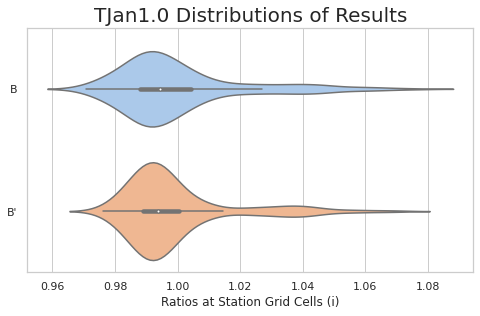

In [14]:
import seaborn as sns

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 4.5))

violindata = np.concatenate([df.ratio, ratio_field[df.irlat, df.irlon]])

b_str = ["B" for x in df.ratio.values]
bp_str = ["B'" for x in ratio_field[df.irlat, df.irlon]]

vstrings = np.concatenate([b_str, bp_str])
vdf = pd.DataFrame({"Ratios at Station Grid Cells (i)": violindata, '': vstrings})

ax.set_title(f"{name} Distributions of Results", fontsize=20)
sns.violinplot(ax=ax, x="Ratios at Station Grid Cells (i)", y='', data=vdf, palette=sns.color_palette('pastel'))

Summarize reconstruction stats

In [15]:
print(
    "Northern fill value:"
    "\n"
    "Reconstruction", reconstructed_field_strip_mean,
    "\n"
    "UAA_station_mean", UAA_station_mean,
    "\n"
    "Combined", combined_ratio_station_mean
)

Northern fill value:
Reconstruction 230.47412249120842 
UAA_station_mean 229.84999999999997 
Combined 230.1620612456042


Convert back to degC if K was used in previous steps. Generate dataset.

In [16]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    print("Convert back to degC")
    K = 273.15 # K
    reconstructed_field -= K
    df[station_dv] -= K
#     ds[dv].attrs["units"] = "degC"

ds_recon = gen_dataset(dv, reconstructed_field, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

Convert back to degC


# Load in NBCC Tables for Comparisons

In [17]:
nrc_path = resource_filename("climpyrical", nbcc_loc_path)
df_nrc = pd.read_excel(nrc_path).iloc[:-1]

# fill problem values with better values from 2015
id_typo = df_nrc[(df_nrc['2020 Longitude'] > 0) | (df_nrc['2020 Latitude'] < 40)].index
df_nrc.loc[id_typo, '2020 Longitude'] = df_nrc['2015 Long.'].values[id_typo]
df_nrc.loc[id_typo, '2020 Latitude'] = df_nrc['2015 Lat.'].values[id_typo]

# process to get the model values
df_nrc.rename(columns={"2020 Longitude": "lon",
                      "2020 Latitude": "lat"})

df_nrc_matched = pd.DataFrame(
    {
     'Location': df_nrc.Location, 
     'Prov': df_nrc.Prov,
     "2020 Elev (m)": df_nrc["2020 Elev (m)"],
     'lon': df_nrc['2020 Longitude'], 
     'lat': df_nrc['2020 Latitude']
     }
    
)

__This step aims to correct the final field to the NBCC 2015 results.__

This is configurable by setting `nbcc_median_correction` to True or False.

1) Find the median of these values. Compute the difference, d = median(R) - median(NRC), and ratio, f = median(R)/median(NRC) 

2) For the non-temperature DVs and HDD, apply the multiplicative correction (1/f)*R_j over the entire reconstruction grid. For the temperature DVs, apply the correction as R_j - d

In [18]:
value = medians["value"]
action = medians["action"]

if action != "add" and action != "multiply" and action != "None":
    raise ValueError("Please provide either add or multiply or None actions in config.")

    
dfp = add_model_values(ds=ds_recon, df=df_nrc_matched)
reconstructed_field_med = ds_recon[dv].values

if nbcc_median_correction:
    if value != "None" or action != "None":
#         med_pcic = np.nanmedian(dfp["model_values"])
        med_pcic = np.nanmean(dfp["model_values"])

        if action == "multiply":
            fr = med_pcic/value
            reconstructed_field_med = (1/fr)*reconstructed_field_med
            print("f:", fr)
        if action == "add":
            d = med_pcic - value
            reconstructed_field_med = reconstructed_field_med - d
            print("d:", d)

INFO:root:Detect units: degC


INFO:root:rlat or rlon not detected in input file.converting assumes WGS84 coords to rotated pole


INFO:root:Matching coordinates now


INFO:root:Locating corresponding model valuesInterpolating to nearest if matched model value is NaN


d: 0.12676771892196115


Re-create dataset if median correction applied

In [19]:
ds_recon = gen_dataset(dv, reconstructed_field_med, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

Populate with headers from the input processed model.

In [20]:
if ds.attrs:
    all_keys = set(ds_recon.variables).union(set(ds_recon.dims))
    for key in all_keys:
        ds_recon[key].attrs = ds[key].attrs
    attr_dict = ds.attrs
    attr_dict["Climpyrical"] = (
        "CanRCM4 Reconstruction contains"
        "hybrid station and model data using"
        "Climpyrical (https://github.com/pacificclimate/climpyrical)"
    )

    ds_recon.attrs = attr_dict
else:
    raise warnings.warn("No attributes detected in dataset file")

In [21]:
ds_recon.to_netcdf(
    resource_filename(
        "climpyrical",
        f"{output_reconstruction_path}{name}_reconstruction.nc"
    ),
    mode="w"
)